In [3]:
!pip install stable-baselines3 torch

In [4]:
import pandas as pd
import numpy as np
import os

In [5]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [6]:
import pandas as pd

def get_forex_data():
    # Load the dataset
    data_set = pd.read_csv('/kaggle/input/forex-dataset/Foreign_Exchange_Rates.csv', na_values='ND')

    # Interpolate missing values to handle missing data
    data_set = data_set.infer_objects(copy=False)  # Ensure non-numeric columns are correctly inferred
    data_set.interpolate(inplace=True)

    # Select only the columns for EUR/USD and JPY/USD exchange rates
    df = data_set[['EURO AREA - EURO/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$']].copy()

    # Add derived column for YEN/EURO exchange rate
    df['YEN/EURO'] = df['UNITED KINGDOM - UNITED KINGDOM POUND/US$'] / df['EURO AREA - EURO/US$']


    return df

In [7]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box


class State:
    def __init__(self, bars_count=30, prediction_count=4):
        self.bars_count = bars_count
        self._prices = None
        self._first_diff = None
        self._offset = None
        self.balance = None
        self.portfolio = None
        self.trade_max_percentage = None

    def reset(self, prices, offset, initial_balance, trade_max_percentage=0.2):
        assert offset >= self.bars_count - 1, "Offset must allow for sufficient historical data"
        self._prices = prices
        first_differences = prices.diff()
        mean_diff = np.mean(first_differences)
        std_diff = np.std(first_differences) 
        
        # Apply Z-score normalization
        # self._first_diff = (first_differences - mean_diff) / std_diff
        # Normalize the first differences using Min-Max normalization
        self._first_diff =  (first_differences - first_differences.min()) / (first_differences.max() - first_differences.min())
        
        self._offset = offset
        self.balance = initial_balance
        self.trade_max_percentage = trade_max_percentage
        self.portfolio = {'USD': initial_balance, 'EUR': 0, 'JPY':0}
        
    
        

    def step(self, action, trade_percentage, reward_type = "Direct"):
        reward = 0
        current_price = self._prices.iloc[self._offset][['EURO AREA - EURO/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'YEN/EURO']].values
        next_price = self._prices.iloc[self._offset+1][['EURO AREA - EURO/US$', 'UNITED KINGDOM - UNITED KINGDOM POUND/US$', 'YEN/EURO']].values
        _, eur_usd,_ = current_price
        _, eur_usd_1,_ = next_price
        max_trade_amount = self.balance * self.trade_max_percentage
        
        # action is an array of floats between -1 and 1
        # USD and EUR, positive means buy EUR
        portfolio_value = (self.portfolio['USD'] + self.portfolio['EUR'] / eur_usd)
        if action[0] > 0:  
            trade_amount =  abs(max_trade_amount*action[0])
            trade_volume = min(self.portfolio['USD'], trade_amount)

            self.portfolio['EUR'] += trade_volume * eur_usd
            self.portfolio['USD'] -= trade_volume
    
        elif action[0] < 0:
            trade_amount =  abs(max_trade_amount*action[0])
            trade_volume = min(self.portfolio['EUR'], trade_amount * eur_usd)
            
            self.portfolio['USD'] += trade_volume / eur_usd
            self.portfolio['EUR'] -= trade_volume

        
        portfolio_value_1 = (self.portfolio['USD'] + self.portfolio['EUR'] / eur_usd_1)

        if reward_type == "Direct":
            if portfolio_value_1 / portfolio_value<=0:
                print(f"ERROR!!! { portfolio_value_1}/{portfolio_value}")
                print(f"portfolio_value = {self.portfolio['USD']} + {self.portfolio['EUR']} / {eur_usd} = {portfolio_value}")
                print(f"portfolio_value_1 = {self.portfolio['USD']} + {self.portfolio['EUR']} / {eur_usd_1} = {portfolio_value_1}")
                reward = 0
                
            else:
                reward = math.log(portfolio_value_1 / portfolio_value)
            
        self.balance = portfolio_value_1
        self._offset += 1
        done = self._offset >= len(self._prices) - 2

        info = {
            "balance": self.balance,  # Include the current balance
            "portfolio": self.portfolio,
            # Add any other relevant fields from the State object if needed
        }

        return reward, done, info


    def encode(self):
        current_prices = self._first_diff.iloc[self._offset]
        encoded_prices = np.array(current_prices[['UNITED KINGDOM - UNITED KINGDOM POUND/US$']]).flatten()
        portfolio_fraction = np.array([self.portfolio['USD'],self.portfolio['EUR']])/self.balance
        encoded_features = np.concatenate([
            encoded_prices,
            portfolio_fraction,
        ])
        return encoded_features.astype(np.float32)
        
    @property
    def shape(self):
        # shape is bars_count * 3 + predictions count
        return (3,)  

In [56]:
from gymnasium.spaces import Discrete, Box
class ForexTradingEnv(Env):
    def __init__(self, df, initial_balance=1000, bars_count=30):
        super(ForexTradingEnv, self).__init__()
        self.df = df
        self.initial_balance = initial_balance
        self.bars_count = bars_count
        self.state = State(bars_count=self.bars_count)
        self.action_space = Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = Box(
            low=0, high=1, shape=self.state.shape, dtype=np.float32
        )
    def seed(self, seed):
        np.random.seed(seed)
    def reset(self, seed=None):
        super().reset(seed=seed)
        rng = np.random.default_rng(seed)
        offset = np.random.randint(self.bars_count - 1, len(self.df) - 1)
        # if input_offset != None:
        #     offset = input_offset
        offset = 4
        self.state.reset(prices=self.df, offset=offset, initial_balance=self.initial_balance)
        return self.state.encode(), {}

    def step(self, action):
        reward, terminated, info = self.state.step(action, trade_percentage=1)
        truncated = self.state._offset >= len(self.df) - 1  
        observation = self.state.encode()
        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        if mode != 'human':
            raise NotImplementedError("Only 'human' rendering mode is supported.")
        print(f"Step: {self.state._offset}")
        print(f"Portfolio: {self.state.portfolio}")
        print(f"Balance: {self.state.balance}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [16]:
# from stable_baselines3 import PPO
# from stable_baselines3.common.env_util import make_vec_env
# from stable_baselines3.common.vec_env import VecNormalize

# import torch
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # Set up the PPO model
# data = get_forex_data()
# # split_index = int(0.8 * len(data))
# # train_data = data.iloc[:split_index]
# # test_data = data.iloc[split_index:]
# kwargs = {"df": data}
# envs = make_vec_env(ForexTradingEnv, n_envs=4,env_kwargs = kwargs )
# # Wrap with VecNormalize to normalize rewards
# envs = VecNormalize(envs, norm_obs=True, norm_reward=True, clip_obs=10.0)
# model = PPO("MlpPolicy", envs, verbose=1, device=device)

# model_path = "/kaggle/working/ppo_forex"
# # Train the model
# try:
#     model.learn(total_timesteps=10000000)  # Adjust `total_timesteps` as needed
# except KeyboardInterrupt:
#     os.makedirs(os.path.dirname(model_path), exist_ok=True)
#     model.save(model_path)
#     print(f"training interrupted. model saved to {model_path}")
# model.save(model_path)
# print(f"Model saved to {model_path}")

# # Load the saved model (if needed)
# model = PPO.load(model_path)




/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-6-eb3fe1ce1b0a>:9: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_set.interpolate(inplace=True)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/from

Using cuda device
training interrupted. model saved to /kaggle/working/ppo_forex
Model saved to /kaggle/working/ppo_forex


/usr/local/lib/python3.10/dist-packages/stable_baselines3/common/save_util.py:437: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  th_object = th.load(file_content, map_locati

In [46]:

import os
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.vec_env import VecNormalize
import torch
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up the PPO model
data = get_forex_data()
kwargs = {"df": data}
envs = make_vec_env(ForexTradingEnv, n_envs=4, env_kwargs=kwargs)
envs = VecNormalize(envs, norm_obs=True, norm_reward=True, clip_obs=10.0)

model_path = "/kaggle/working/ppo_forex.zip"  # Ensure the correct file extension
log_dir = "/kaggle/working/ppo_logs/"

# Load the existing model if it exists, otherwise create a new one
if os.path.exists(model_path):
    print(f"Loading existing model from {model_path}...")
    model = PPO.load(model_path, env=envs, device=device, tensorboard_log=log_dir)
else:
    print("No existing model found. Training from scratch...")
    model = PPO("MlpPolicy", envs, verbose=1, device=device)

# Train the model
try:
    model.learn(total_timesteps=10_000_000)  # Adjust as needed
except KeyboardInterrupt:
    model.save(model_path)
    print(f"Training interrupted. Model saved to {model_path}")

# Save the model after training
model.save(model_path)
print(f"Model saved to {model_path}")

Loading existing model from /kaggle/working/ppo_forex.zip...
Logging to /kaggle/working/ppo_logs/PPO_5


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 823      |
|    ep_rew_mean     | 0.0495   |
| time/              |          |
|    fps             | 708      |
|    iterations      | 1        |
|    time_elapsed    | 11       |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1.19e+03    |
|    ep_rew_mean          | 0.0833      |
| time/                   |             |
|    fps                  | 574         |
|    iterations           | 2           |
|    time_elapsed         | 28          |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.012155324 |
|    clip_fraction        | 0.13        |
|    clip_range           | 0.2         |
|    entropy_loss         | 1.54        |
|    explained_variance   | 0.224       |
|    learning_rate        | 0.

In [10]:
# obs = envs.reset()
# while True:
#     action, _states = model.predict(obs)
#     print(action)
#     obs, rewards, dones, info = envs.step(action)
#     if dones.any():
#         break  # Exit loop when an episode ends
#     # Render or log as needed
#     # print(rewards)
# print("Evaluation complete!")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(a

[[-1.        ]
 [-1.        ]
 [ 0.9524256 ]
 [-0.80495524]]
[[ 1.        ]
 [ 0.9929301 ]
 [ 0.26152128]
 [-0.11613135]]
[[-0.8884026]
 [-0.5580142]
 [ 0.1741007]
 [ 1.       ]]
[[ 1.        ]
 [-1.        ]
 [-0.62536776]
 [-0.28332072]]
[[ 0.20970577]
 [-0.5293476 ]
 [-0.18453693]
 [-0.03715613]]
[[ 0.00629643]
 [ 0.14376336]
 [-1.        ]
 [ 0.6544068 ]]
[[-0.8591186 ]
 [-0.60912895]
 [-1.        ]
 [-1.        ]]
[[ 0.16617629]
 [-0.81558484]
 [ 0.843081  ]
 [-0.73373747]]
[[-0.04198772]
 [-0.0517332 ]
 [ 0.5091237 ]
 [ 0.09720045]]
[[ 0.03791067]
 [-0.2304191 ]
 [-1.        ]
 [ 0.38259232]]
[[-1.        ]
 [-0.21962997]
 [-0.6670735 ]
 [ 0.04475951]]
[[-0.5122624]
 [-0.9037769]
 [ 1.       ]
 [-1.       ]]
[[ 0.6111584 ]
 [ 0.2564106 ]
 [-0.76414144]
 [ 0.31805462]]
[[-0.21010864]
 [-0.7835363 ]
 [ 0.67241335]
 [ 0.07242802]]
[[ 1.        ]
 [ 0.36728868]
 [-1.        ]
 [ 0.16789186]]
[[-1.        ]
 [-0.52030075]
 [ 0.14290795]
 [-0.03706124]]
[[ 0.54920614]
 [ 0.33137906]
 [

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3643: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)


In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# portfolio_history = [
#     {"USD": [], "EUR": [], "BLC": []} for _ in range(envs.num_envs)
# ]

# # Reset the environments
# obs = envs.reset()
# while True:
#     # Get the predicted action from the model
#     action, _states = model.predict(obs)
#     # Perform the action in the environment
#     obs, rewards, dones, infos = envs.step(action)
    
#     # Append the portfolio values for each environment
#     for i, info in enumerate(infos):
#         portfolio = info["portfolio"]
#         portfolio_history[i]["USD"].append(portfolio.get("USD"))
#         portfolio_history[i]["EUR"].append(portfolio.get("EUR"))
#         portfolio_history[i]["BLC"].append(info["balance"])

#     # Break the loop when an episode ends
#     if dones.any():
#         break

# print("Evaluation complete!")

# # Plot the portfolio progression for each environment
# for i in range(envs.num_envs):
#     plt.figure(figsize=(10, 6))
#     plt.plot(portfolio_history[i]["USD"], label="USD", color="blue")
#     plt.plot(portfolio_history[i]["EUR"], label="EUR", color="green")
#     plt.plot(portfolio_history[i]["BLC"], label="BLC", color="red")
#     plt.title(f"Portfolio Progression in Environment {i + 1}")
#     plt.xlabel("Steps")
#     plt.ylabel("Portfolio Value")
#     plt.legend()
#     plt.grid()
#     plt.show()

Evaluation complete!


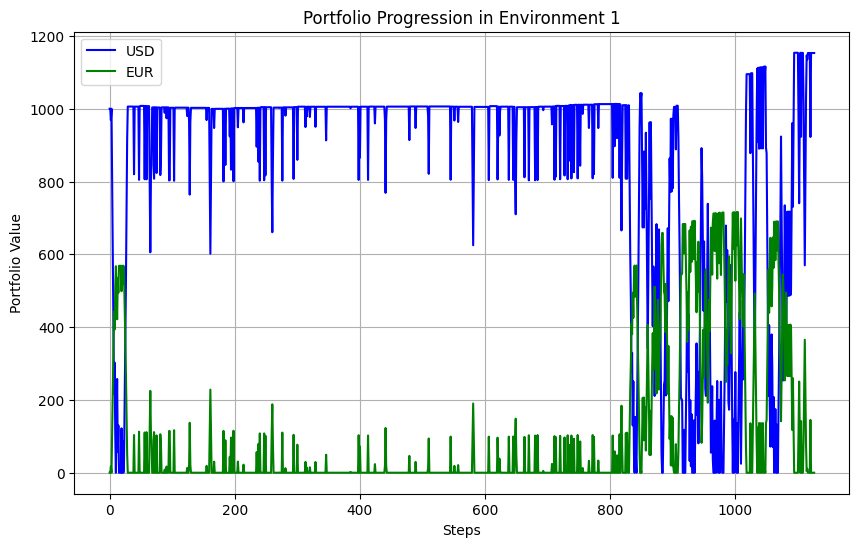

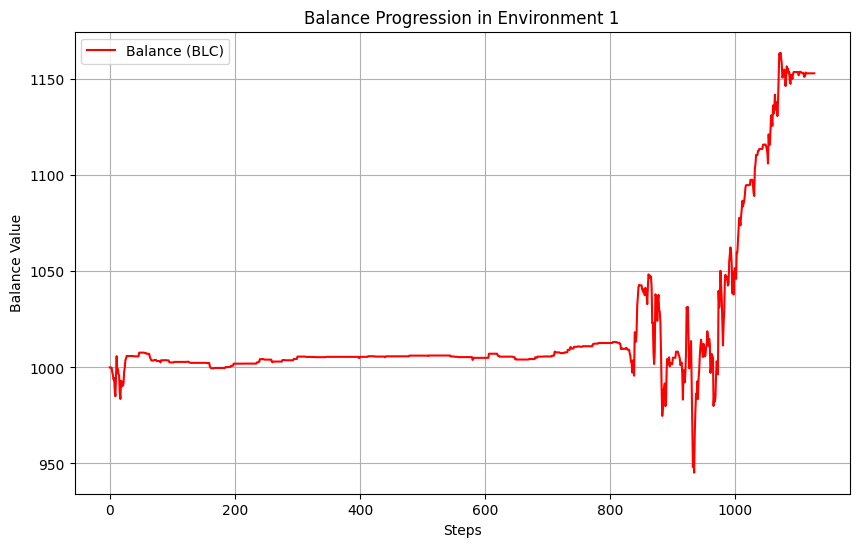

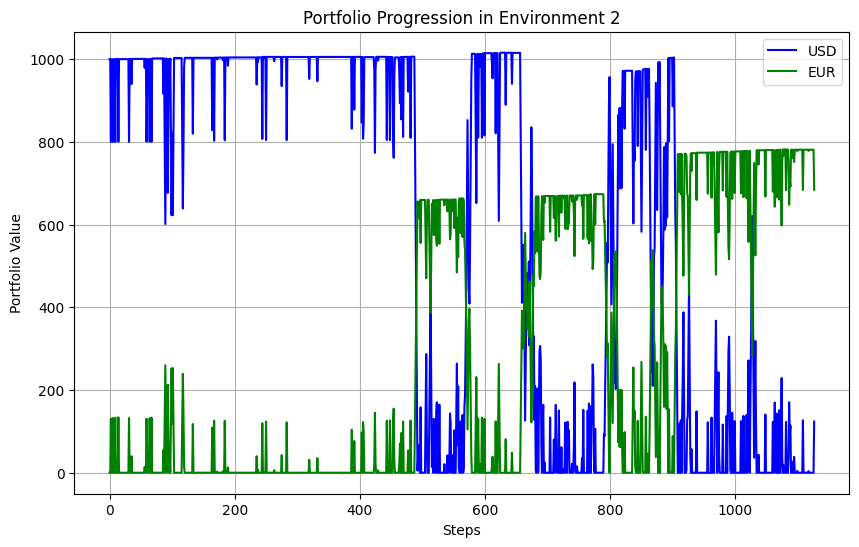

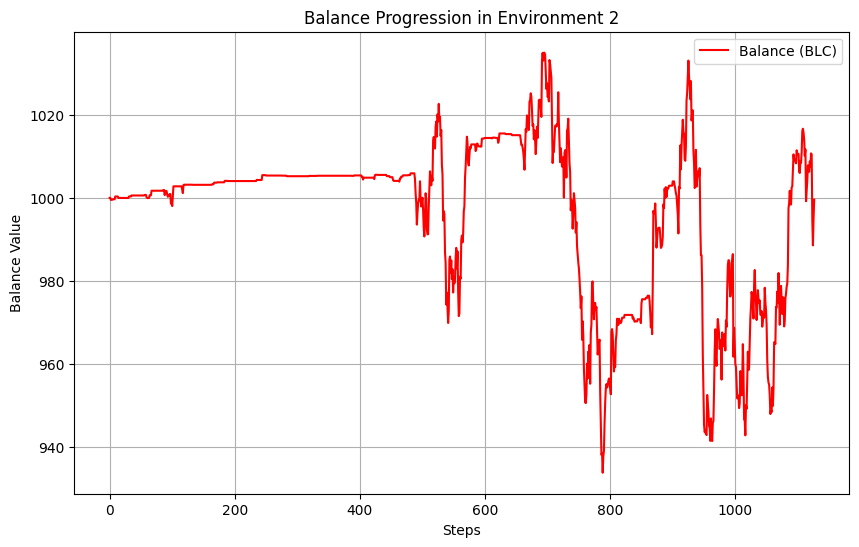

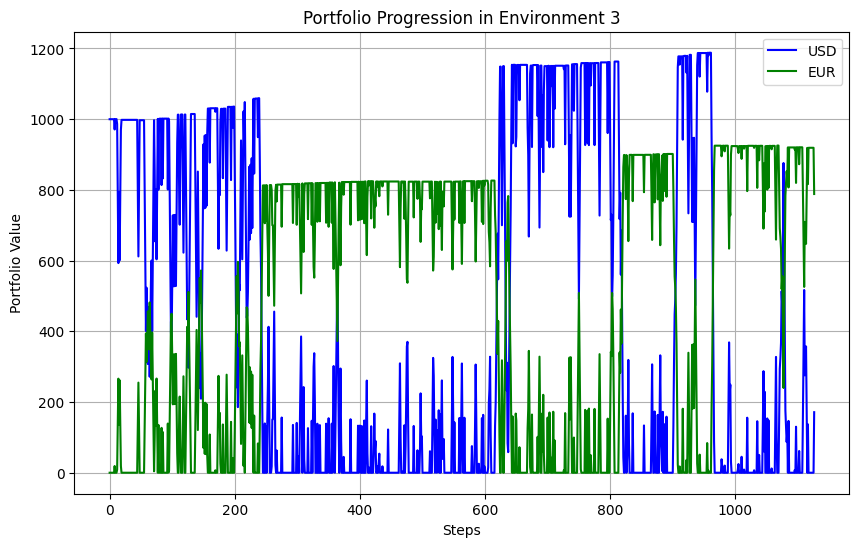

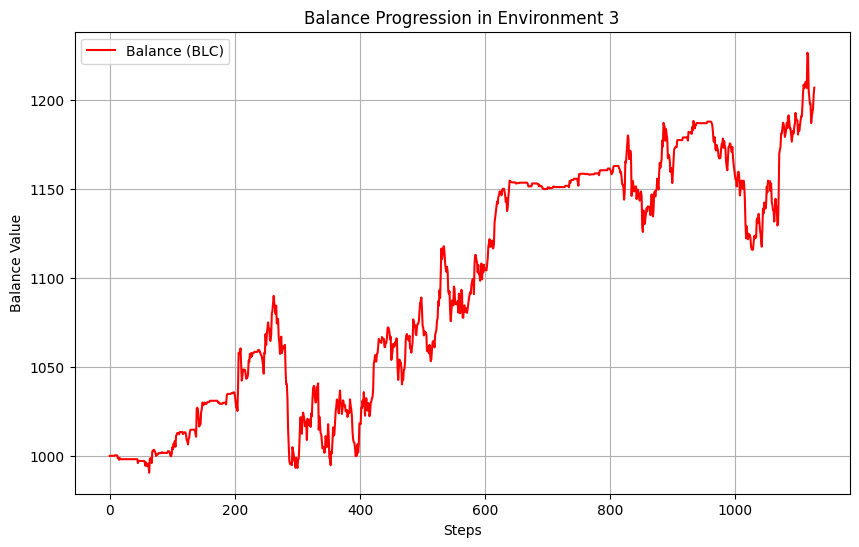

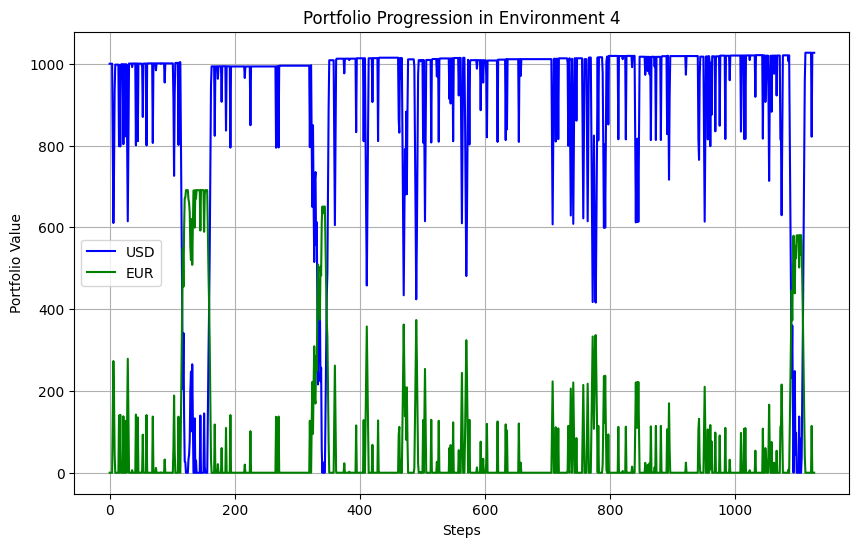

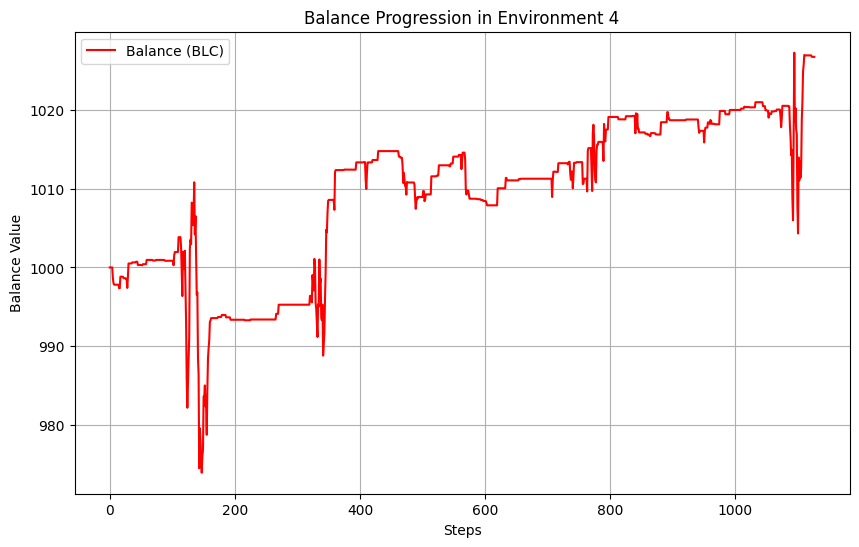

In [57]:

import matplotlib.pyplot as plt
import numpy as np

portfolio_history = [
    {"USD": [], "EUR": [], "BLC": []} for _ in range(envs.num_envs)
]

# Reset the environments
obs = envs.reset()
while True:
    # Get the predicted action from the model
    action, _states = model.predict(obs)
    # Perform the action in the environment
    obs, rewards, dones, infos = envs.step(action)
    
    # Append the portfolio values for each environment
    for i, info in enumerate(infos):
        portfolio = info["portfolio"]
        portfolio_history[i]["USD"].append(portfolio.get("USD"))
        portfolio_history[i]["EUR"].append(portfolio.get("EUR"))
        portfolio_history[i]["BLC"].append(info["balance"])

    # Break the loop when an episode ends
    if dones.any():
        break

print("Evaluation complete!")

# # Plot the portfolio progression for each environment (USD and EUR only)
# for i in range(envs.num_envs):
#     plt.figure(figsize=(10, 6))
#     plt.plot(portfolio_history[i]["USD"], label="USD", color="blue")
#     plt.plot(portfolio_history[i]["EUR"], label="EUR", color="green")
#     plt.title(f"Portfolio Progression in Environment {i + 1}")
#     plt.xlabel("Steps")
#     plt.ylabel("Portfolio Value")
#     plt.legend()
#     plt.grid()
#     plt.show()

# # Plot the balance (BLC) separately
# for i in range(envs.num_envs):
#     plt.figure(figsize=(10, 6))
#     plt.plot(portfolio_history[i]["BLC"], label="Balance (BLC)", color="red")
#     plt.title(f"Balance Progression in Environment {i + 1}")
#     plt.xlabel("Steps")
#     plt.ylabel("Balance Value")
#     plt.legend()
#     plt.grid()
#     plt.show()

# Plot portfolio progression (USD and EUR) followed by balance (BLC) for each environment
for i in range(envs.num_envs):
    # Plot portfolio (USD & EUR)
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history[i]["USD"], label="USD", color="blue")
    plt.plot(portfolio_history[i]["EUR"], label="EUR", color="green")
    plt.title(f"Portfolio Progression in Environment {i + 1}")
    plt.xlabel("Steps")
    plt.ylabel("Portfolio Value")
    plt.legend()
    plt.grid()
    plt.show()
    
    # Plot balance (BLC) after the portfolio plot
    plt.figure(figsize=(10, 6))
    plt.plot(portfolio_history[i]["BLC"], label="Balance (BLC)", color="red")
    plt.title(f"Balance Progression in Environment {i + 1}")
    plt.xlabel("Steps")
    plt.ylabel("Balance Value")
    plt.legend()
    plt.grid()
    plt.show()
